Here we study the system's behavior in summer, from August 1st to August 7th, using the input data file provided by the code in the Inputs_changes.ipynb file.

A controller regulates the indoor temperature to 20°C.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

controller = True
Kp = 1e3
explicit_Euler = True
imposed_time_step = False
Δt = 3600    # s, imposed time step   

# MODEL
# =====
# Thermal circuits
TC = dm4bem.file2TC('TC.csv', name='', auto_number=False)

# by default TC['G']['q11'] = 0 # Kp -> 0, no controller (free-floating
if controller:
    TC['G']['q11'] = Kp     # Kp -> ∞, almost perfect controller

# State-space
[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)

λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)    # max time step for Euler explicit stability
dt = dm4bem.round_time(dtmax)

if imposed_time_step:
    dt = Δt

dm4bem.print_rounded_time('dt', dt)



dt = 50 s


For the input data set, we use the .csv file given by the "inputs_changes" code named "input_data_set_august".

In [2]:
# INPUT DATA SET
# ==============
input_data_set = pd.read_csv('input_data_set_august.csv',
                             index_col=0,
                             parse_dates=True)
input_data_set
input_data_set = input_data_set.resample(
    str(dt) + 'S').interpolate(method='linear')
input_data_set.head()
# Input vector in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)
u.head()

# Initial conditions
θ0 = 20                     # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0
I = np.eye(As.shape[0])     # identity matrix

if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs @ u.iloc[k]
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k])
# outputs
y = (Cs @ θ.T + Ds @  u.T).T
Kp = TC['G']['q11']     # controller gain
S = 9                   # m², surface area of the toy house
q_HVAC = Kp * (u['q11'] - y['θ6']) / S  # W/m²
y['θ6']
data = pd.DataFrame({'To': input_data_set['To'],
                     'θi': y['θ6'],
                     'Etot': input_data_set['Etot'],
                     'q_HVAC': q_HVAC})

plt.show();
t = dt * np.arange(data.shape[0])   # time vector

# Visualisation of the results 

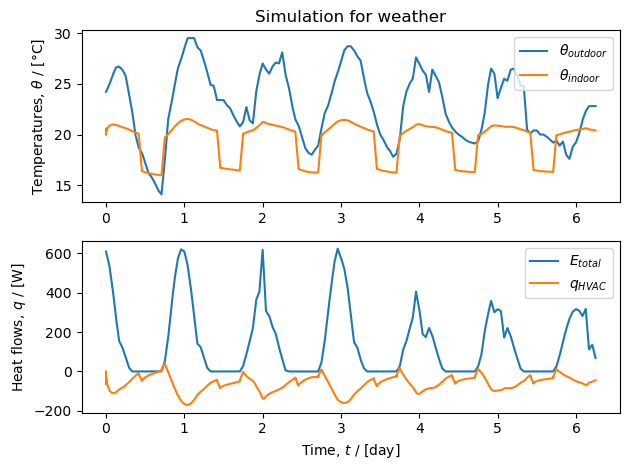

In [3]:
fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y.values, label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Etot'], label='$E_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / [day]',
           ylabel='Heat flows, $q$ / [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

Analyse :
    
In summer, outdoor temperature is usually higher than indoor temperature, here set at 20°C. The first graph shows it. 
The outdoor temperature follows the variations of $E_{tot}$, the total solar radiation intensity on the wall. The more radiation there is, the higher the outdoor temperature will be.
As outdoor temperature is bigger than 20°C, the power that the HVAC system needs to deliver to maintain the indoor air temperature at 20°C is negativ. 

The indoor air needs to be cooled, unlike in winter when heating is required to reach the desired temperature.
According to the second graph, as radiation increases, the heat flow intensifies to lower the indoor temperature. 